# AB Browser Testing

В данном задании вам нужно будет

   - проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса
   - подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами
   - определить характер этих изменений и практическую значимость вводимого изменения
   - понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения (локализовать изменение)

  - userID:  уникальный идентификатор пользователя
  - browser:  браузер, который использовал userID
  - slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)
  - n_clicks: количество кликов, которые пользоваль совершил за n_queries    n_queries: количество запросов, который совершил userID, пользуясь браузером browser
  - n_nonclk_queries: количество запросов пользователя, в которых  им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных  уникальным является сочетание userID и browser.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [143]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.stats.multitest as smm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.sandbox.stats.multicomp import multipletests 
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *
import matplotlib.pyplot as plt

In [3]:
print(np.__version__)
print(pd.__version__)
print(sc.__version__)
print(statsmodels.__version__)

1.19.2
1.2.1
1.5.2
0.12.1


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
data = pd.read_csv('ab_browser_test.csv', sep=',')
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [6]:
data.shape

(566134, 6)

In [12]:
data.browser.unique()

array(['Browser #2', 'Browser #4', 'Browser #14', 'Browser #17',
       'Browser #20', 'Browser #22'], dtype=object)

## Task 1

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы. 

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите  до третьего знака после точки. 

In [39]:
data.slot.value_counts()

control    284554
exp        281580
Name: slot, dtype: int64

In [44]:
exp_clicks_sum = data[data['slot'] == 'exp'].n_clicks.sum()
control_clicks_sum = data[data['slot'] == 'control'].n_clicks.sum()

In [45]:
print("Total exp clicks: \t\t {}".format(exp_clicks_sum))
print("Total conrol clicks: \t\t {}".format(control_clicks_sum))
print("Total exp + control clicks: \t {}".format(exp_clicks_sum + control_clicks_sum))

Total exp clicks: 		 3261823
Total conrol clicks: 		 3210027
Total exp + control clicks: 	 6471850


In [46]:
percentage = round((exp_clicks_sum/control_clicks_sum - 1)*100,3)

In [47]:
print('The number of clicks in experience group is greate then in control on {}%'.format(percentage))

The number of clicks in experience group is greate then in control on 1.614%


ОТВЕТ:(1 бал)
- 1.614

## Task 2

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

In [42]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [43]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Для начала посчитаем просто медианы и средние для контрольной и експериментальной груп.

In [49]:
exp_clicks = data[data['slot'] == 'exp'].n_clicks
control_clicks = data[data['slot'] == 'control'].n_clicks

In [58]:
print('Median of clicks for exp group: {}'.format(exp_clicks.median()))
print('Median of clicks for control group: {}'.format(control_clicks.median()))

Median of clicks for exp group: 5.0
Median of clicks for control group: 4.0


In [60]:
print('Mean of clicks for exp group: {}'.format(round(exp_clicks.mean(), 2)))
print('Mean of clicks for control group: {}'.format(round(control_clicks.mean(), 2)))

Mean of clicks for exp group: 11.58
Mean of clicks for control group: 11.28


In [215]:
%%time
np.random.seed(0)

exp_bootstrap = get_bootstrap_samples(exp_clicks.values,n_samples=500)
exp_boot_median = np.median(exp_bootstrap, axis=1)
exp_boot_mean = np.mean(exp_bootstrap, axis=1)

control_bootstrap = get_bootstrap_samples(control_clicks.values,n_samples=500)
control_boot_median = np.median(control_bootstrap, axis=1)
control_boot_mean = np.mean(control_bootstrap, axis=1)

CPU times: user 8.71 s, sys: 620 ms, total: 9.33 s
Wall time: 9.33 s


In [218]:
print('Bootstrap exp median confidance interval: {}'.format(stat_intervals(exp_boot_median,alpha=0.05)))
print('Bootstrap control median confidance interval: {}'.format(stat_intervals(control_boot_median,alpha=0.05)))

Bootstrap exp median confidance interval: [5. 5.]
Bootstrap control median confidance interval: [4. 4.]


In [219]:
print('Bootstrap exp mean confidance interval: {}'.format(stat_intervals(exp_boot_mean,alpha=0.05)))
print('Bootstrap control mean confidance interval: {}'.format(stat_intervals(control_boot_mean,alpha=0.05)))

Bootstrap exp mean confidance interval: [11.50789349 11.6588664 ]
Bootstrap control mean confidance interval: [11.20668696 11.35347509]


### Интервальная оценка для разности медиан и средних на бутстрепе

In [220]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(exp_boot_median, control_boot_median)))
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(exp_boot_mean, control_boot_mean)))

In [221]:
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% conf. int. for the difference between medians: [%f, %f]' % (stat_int[0], stat_int[1]))

95% conf. int. for the difference between medians: [-1.000000, -1.000000]


In [222]:
stat_int = stat_intervals(delta_mean_scores, 0.05)
print('95%% conf. int. for the difference between means: [%f, %f]' % (stat_int[0], stat_int[1]))

95% conf. int. for the difference between means: [-0.404967, -0.199603]


ОТВЕТ:(1 бал)
- NOT 95% доверительный интервал для разности средних не содержит ноль, похоже, средние существенно отличаются
- NOT 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы существенно отличаются

## Task 3

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и  значимым статистически. Последнее утверждение нуждается в дополнительной проверке. 

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах. 

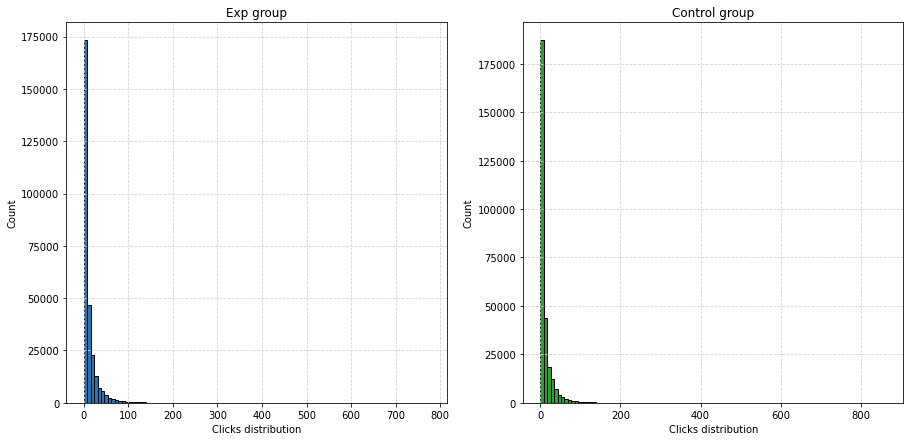

In [79]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(exp_clicks.values, color ='tab:blue',edgecolor='k', bins=100)
pylab.xlabel('Clicks distribution')
pylab.ylabel('Count')
pylab.title('Exp group')

pylab.subplot(1,2,2)
pylab.grid(color='lightgrey', linestyle='--')
pylab.hist(control_clicks.values, color = 'tab:green', edgecolor='k', bins=100)
pylab.xlabel('Clicks distribution')
pylab.ylabel('Count')
pylab.title('Control group')

pylab.show()

ОТВЕТ: (1 бал)
- все ответы не верны

## Task 4

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных. 

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных. 

Для простоты рассмотрим одновыборочный t-критерий.  Его статистика имеет вид  $Xˉ−μS2/n \frac{\bar{X} - \mu}{ \sqrt {S^2 / n}} S2/n$

$X − μ$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

    $X¯$  —  среднее значение в выборке — было распределено нормально N(μ,σ2n)
    $nσ2S2$  — несмещенная оценка дисперсии c масштабирующим коэффициентом —  была распределена по хи-квадрат  c n−1 степенями свободы  $χ2(n−1) $

Простое доказательство необходимости и достаточности этого требования  можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными  в рамках данного вопроса. 

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого 

  1. Получите из данных n_boot_samples  псевдовыборок. 
  2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared) 
  3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
  4.Для получившегося вектора  сумм квадратов отклонения от выборочного среднего постройте  qq-plot с помощью scipy.stats.probplot  для хи-квадрат распределения с помощью команды 

In [83]:
%%time
np.random.seed(0)

exp_bootstrap = get_bootstrap_samples(exp_clicks.values,n_samples=500)
exp_boot_mean = np.mean(exp_bootstrap, axis=0)

control_bootstrap = get_bootstrap_samples(control_clicks.values,n_samples=500)
control_boot_mean = np.mean(control_bootstrap, axis=0)

CPU times: user 5.6 s, sys: 380 ms, total: 5.98 s
Wall time: 5.98 s


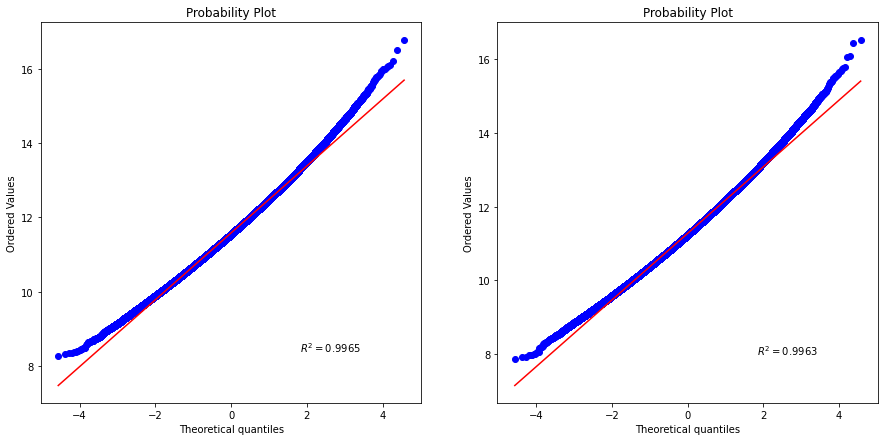

In [85]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
sc.stats.probplot(exp_boot_mean, dist="norm", plot=pylab, rvalue=True)
pylab.subplot(1,2,2)
sc.stats.probplot(control_boot_mean, dist="norm", plot=pylab, rvalue=True)

pylab.show()

In [223]:
%%time
np.random.seed(0)

exp_bootstrap = get_bootstrap_samples(exp_clicks.values,n_samples=500)
exp_boot_var = np.var(exp_bootstrap, axis=1)

control_bootstrap = get_bootstrap_samples(control_clicks.values,n_samples=500)
control_boot_var = np.var(control_bootstrap, axis=1)

CPU times: user 6.08 s, sys: 557 ms, total: 6.64 s
Wall time: 6.64 s


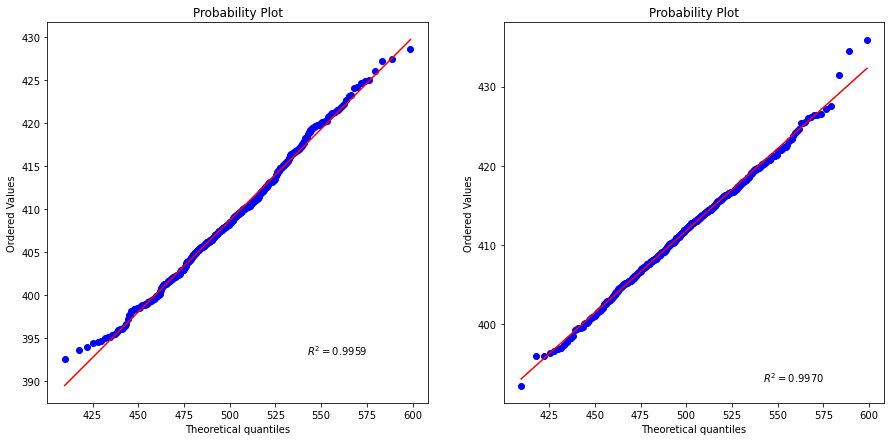

In [224]:
pylab.figure(figsize=(15,7))

pylab.subplot(1,2,1)
sc.stats.probplot(exp_boot_var, dist="chi2", sparams=(exp_boot_var.shape[0]-1), plot=pylab, rvalue=True)
pylab.subplot(1,2,2)
sc.stats.probplot(control_boot_var, dist="chi2", sparams=(control_boot_var.shape[0]-1), plot=pylab, rvalue=True)

pylab.show()

ОТВЕТ: (1 бал)
- NOT R2 для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99
- NOT R2 для выборочного среднего получился больше, чем  0.99

## Task 5

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control  и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [116]:
users_nclicks_exp = data[data['slot'] == 'exp'].groupby(['userID'])['n_clicks'].agg([np.sum])

In [120]:
users_nclicks_control = data[data['slot'] == 'control'].groupby(['userID'])['n_clicks'].agg([np.sum])

In [122]:
sc.stats.mannwhitneyu(users_nclicks_exp, users_nclicks_control, alternative='two-sided')

MannwhitneyuResult(statistic=41140868471.0, pvalue=8.694294377520879e-75)

ОТВЕТ: (1 бал)
- Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между  двумя выборками

## Task 6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05\alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [127]:
browser_nclicks_exp = data[data['slot'] == 'exp'].groupby(['browser','userID'])['n_clicks'].agg([np.sum])

In [128]:
browser_nclicks_control = data[data['slot'] == 'control'].groupby(['browser','userID'])['n_clicks'].agg([np.sum])

In [188]:
browsers = np.unique(data.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    _, mw_p[i] = sc.stats.mannwhitneyu(browser_nclicks_exp.loc[br, :], browser_nclicks_control.loc[br, :], alternative='two-sided')
    print('{}: '.format(br),end=' '),    
    print('\t p-value = %.4f' % mw_p[i])
    
print('')
print('Mann-Whitney rank test with multipletest')
rejected, mw_p_corr, _, _ = multipletests(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print('{}: '.format(br),end=' '),
    print('\t p-value = {} \t- {}'.format(round(mw_p_corr[i],1),rejected[i]))


Unique browsers numbers: ['Browser #14' 'Browser #17' 'Browser #2' 'Browser #20' 'Browser #22'
 'Browser #4']

Mann-Whitney rank test without multipletest
Browser #14:  	 p-value = 0.0000
Browser #17:  	 p-value = 0.0748
Browser #2:  	 p-value = 0.0545
Browser #20:  	 p-value = 0.9073
Browser #22:  	 p-value = 0.5148
Browser #4:  	 p-value = 0.8152

Mann-Whitney rank test with multipletest
Browser #14:  	 p-value = 0.0 	- True
Browser #17:  	 p-value = 0.3 	- False
Browser #2:  	 p-value = 0.3 	- False
Browser #20:  	 p-value = 1.0 	- False
Browser #22:  	 p-value = 1.0 	- False
Browser #4:  	 p-value = 1.0 	- False


ОТВЕТ: (1 бал)
- 5

## Task 7

Для каждого браузера в каждой из двух групп (control  и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений  n_nonclk_queries  на сумму значений  n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче  проинтерпретировать.

In [176]:
browser_n_queries_exp = data[data['slot'] == 'exp'].groupby(['browser'])['n_queries'].agg(np.sum)
browser_n_nonclk_queries_exp = data[data['slot'] == 'exp'].groupby(['browser'])['n_nonclk_queries'].agg(np.sum)
browsers_nonclk_q_prop_exp = browser_n_nonclk_queries_exp / browser_n_queries_exp

In [177]:
browser_n_queries_control = data[data['slot'] == 'control'].groupby(['browser'])['n_queries'].agg(np.sum)
browser_n_nonclk_queries_control = data[data['slot'] == 'control'].groupby(['browser'])['n_nonclk_queries'].agg(np.sum)
browsers_nonclk_q_prop_control = browser_n_nonclk_queries_control / browser_n_queries_control

In [178]:
table = pd.DataFrame(data=None, columns=['Browser','Exp','Control'])
table['Browser'] = browsers
table['Exp'] = browsers_nonclk_q_prop_exp.values
table['Control'] = browsers_nonclk_q_prop_control.values

In [183]:
table.sort_values(['Browser'])

,Browser,Exp,Control
0,Browser #14,0.437556,0.575904
1,Browser #17,0.369374,0.362994
2,Browser #2,0.449827,0.459627
3,Browser #20,0.389774,0.405405
4,Browser #22,0.398539,0.405940
5,Browser #4,0.451429,0.469709


ОТВЕТ: (1 бал)
- С помощью анализа